In [76]:
import os
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import v2
import cv2
import random
from PIL import Image, ImageChops
import torchvision.transforms.functional as TF

In [77]:
class FingerDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [f for f in os.listdir(directory) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.directory, image_name)
        image = Image.open(image_path)  # Open the image file as a PIL Image
        label = int(image_name.split('_')[0])  # Parse the label

        if self.transform:
            image = self.transform(image)  # Apply the transformations

        return image, label

In [78]:
class RandomShadows(object):
    def __init__(self, p=0.5, high_ratio=(1,2), low_ratio=(0.01, 0.5), left_low_ratio=(0.4,0.6), \
    left_high_ratio=(0,0.2), right_low_ratio=(0.4,0.6), right_high_ratio = (0,0.2)):
        self.p = p
        self.high_ratio = high_ratio
        self.low_ratio = low_ratio
        self.left_low_ratio = left_low_ratio
        self.left_high_ratio = left_high_ratio
        self.right_low_ratio = right_low_ratio
        self.right_high_ratio = right_high_ratio

    @staticmethod
    def process(img, high_ratio, low_ratio, left_low_ratio, left_high_ratio, \
            right_low_ratio, right_high_ratio):

        w, h = img.size
        high_bright_factor = random.uniform(high_ratio[0], high_ratio[1])
        low_bright_factor = random.uniform(low_ratio[0], low_ratio[1])

        left_low_factor = random.uniform(left_low_ratio[0]*h, left_low_ratio[1]*h)
        left_high_factor = random.uniform(left_high_ratio[0]*h, left_high_ratio[1]*h)
        right_low_factor = random.uniform(right_low_ratio[0]*h, right_low_ratio[1]*h)
        right_high_factor = random.uniform(right_high_ratio[0]*h, right_high_ratio[1]*h)

        tl = (0, left_high_factor)
        bl = (0, left_high_factor+left_low_factor)

        tr = (w, right_high_factor)
        br = (w, right_high_factor+right_low_factor)

        contour = np.array([tl, tr, br, bl], dtype=np.int32)

        mask = np.zeros([h, w, 3],np.uint8)
        cv2.fillPoly(mask,[contour],(255,255,255))
        inverted_mask = cv2.bitwise_not(mask)
        # we need to convert this cv2 masks to PIL images
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # we skip the above convertion because our mask is just black and white
        mask_pil = Image.fromarray(mask)
        inverted_mask_pil = Image.fromarray(inverted_mask)

        low_brightness = TF.adjust_brightness(img, low_bright_factor)
        low_brightness_masked = ImageChops.multiply(low_brightness, mask_pil)
        high_brightness = TF.adjust_brightness(img, high_bright_factor)
        high_brightness_masked = ImageChops.multiply(high_brightness, inverted_mask_pil)

        return ImageChops.add(low_brightness_masked, high_brightness_masked)

    def __call__(self, img):
        if random.uniform(0, 1) < self.p:
            img = self.process(img, self.high_ratio, self.low_ratio, \
            self.left_low_ratio, self.left_high_ratio, self.right_low_ratio, \
            self.right_high_ratio)
            return img
        else:
            return img

In [79]:





train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((256, 256)),
    #transforms.RandomCrop(32),
    v2.GaussianBlur(5, sigma=(0.1, 2.0)),
    v2.ToPILImage(),
    transforms.ToTensor(),
    
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])



validate_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    #transforms.RandomCrop(32),
    v2.GaussianBlur(5, sigma=(0.1, 2.0)),
    v2.ToPILImage(),
    transforms.ToTensor(),
    
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


# validate_transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
# ])

In [80]:
train_dataset = FingerDataset(directory='dataset/rokas_train', transform=train_transform)
validate_dataset = FingerDataset(directory='dataset/rokas_validate', transform=validate_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=False)


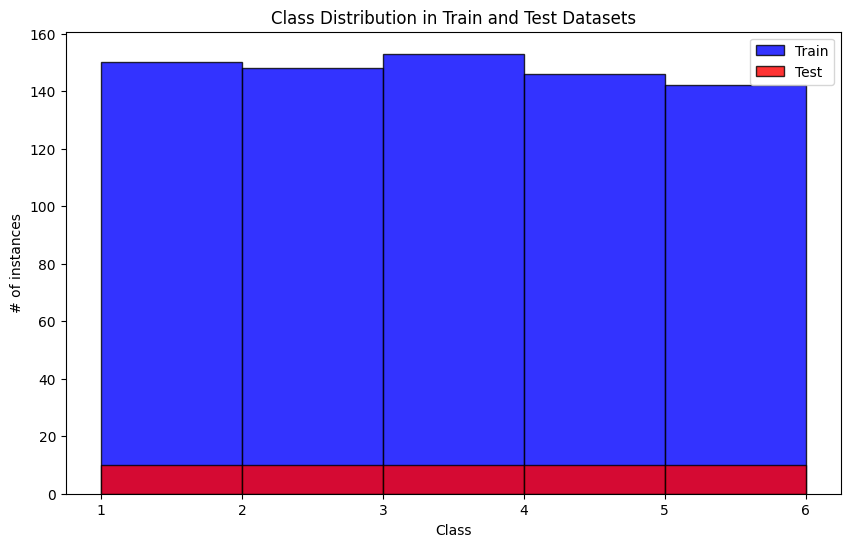

In [81]:
def get_labels(dataloader):
    labels1 = []
    for _, label_batch in dataloader:
        labels1.extend(label_batch.numpy())
    return labels1

train_labels = get_labels(train_loader)
test_labels = get_labels(validate_loader)
plt.figure(figsize=(10, 6))
h1, _, _ = plt.hist(train_labels, bins=range(1, 7), alpha=0.8, color='blue', edgecolor='black')
h2, _, _ = plt.hist(test_labels, bins=range(1, 7), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')
plt.title('Class Distribution in Train and Test Datasets')
plt.legend(['Train', 'Test'])
plt.show()

torch.Size([32, 3, 256, 256]) torch.Size([32])


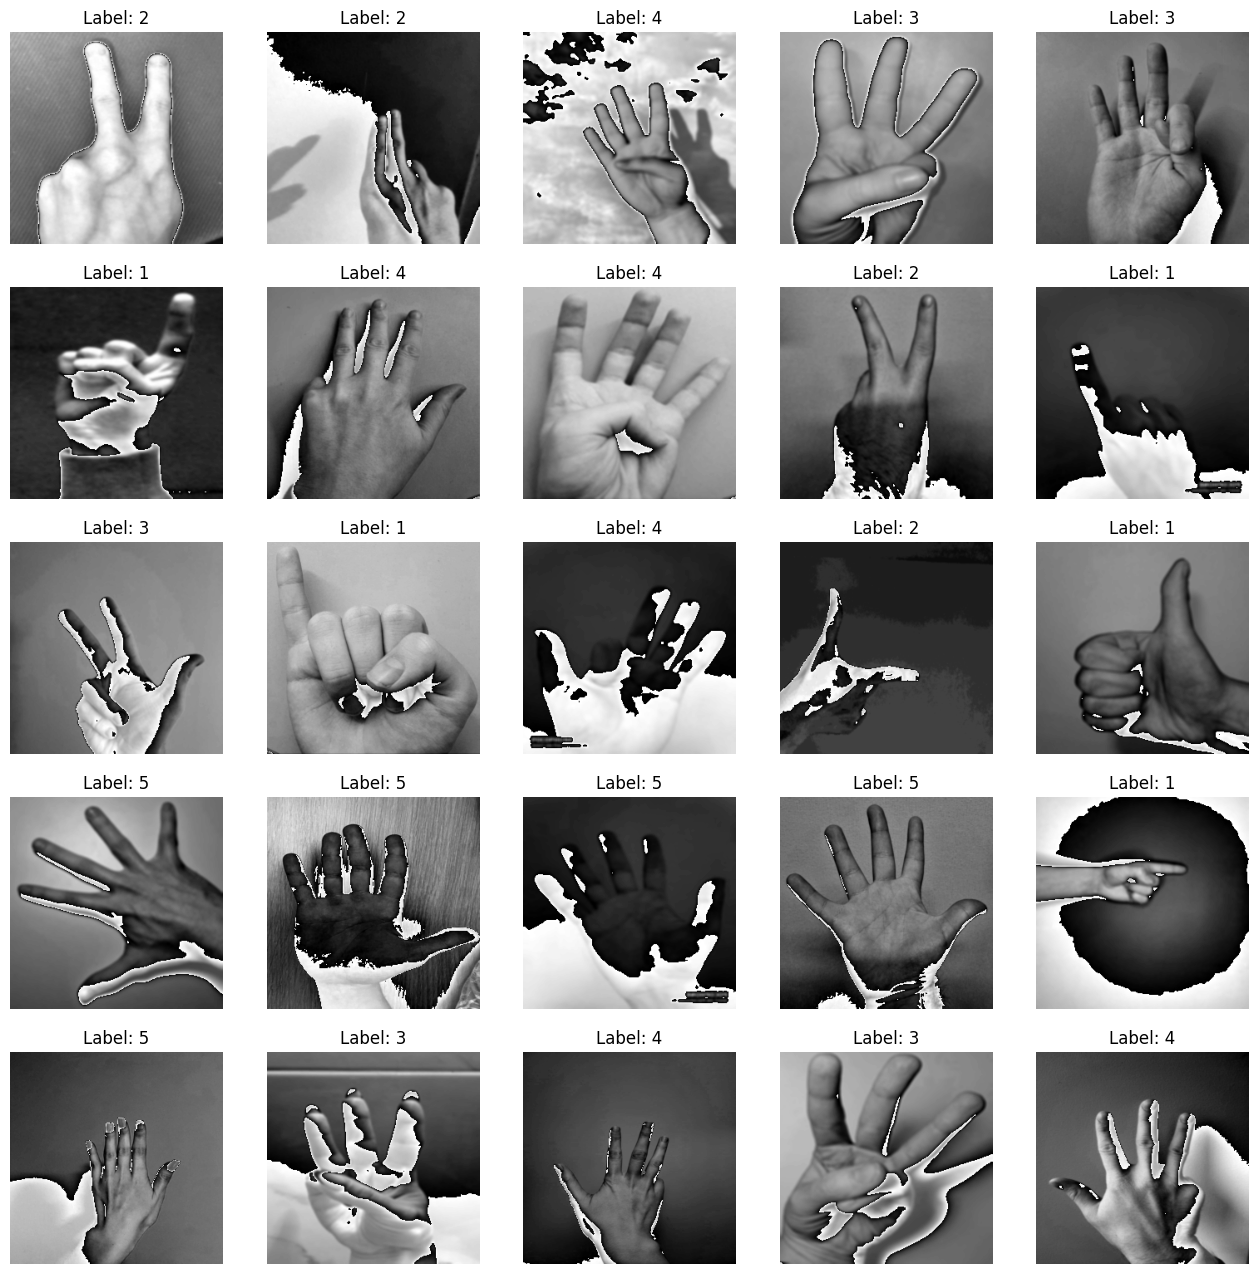

In [82]:
for X, y in train_loader:
    print(X.shape, y.shape)
    
    plt.figure(figsize=(16, 16))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        
        label = y[i].item() if len(y[i].shape) == 0 else np.argmax(y[i].numpy())
        plt.title(f'Label: {label}')
        
        img = np.uint8(255 * X[i].numpy().transpose((1, 2, 0))[:,:,0])  
        plt.imshow(img, cmap='gray')
        plt.axis('off')  
    
    plt.show()
    break 

In [83]:
class FingerCNN(nn.Module):
    def __init__(self):
        super(FingerCNN,self).__init__()

        #conv 1
        self.cnn1=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu1=nn.ReLU()

        #Maxpool 1
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        #conv 2
        self.cnn2=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.relu2=nn.ReLU()

        #Maxpool 2
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        #conv 3
        self.cnn3=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=2)
        self.relu3=nn.ReLU()

        #Maxpool 3
        self.maxpool3=nn.MaxPool2d(kernel_size=2)

        #conv 4
        self.cnn4=nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=2)
        self.relu4=nn.ReLU()

        #Maxpool 4
        self.maxpool4=nn.MaxPool2d(kernel_size=2)

        # FC 1
        self.fc1=nn.Linear(36992,512)
        self.relu5=nn.ReLU()
        
        #FC 2
        self.fc2=nn.Linear(512,6)

    def forward(self,x):
        # ori=x[0][0].data.numpy()
        # print ('original : '),ori.shape
        # plt.imshow(ori, cmap=plt.get_cmap('gray'))
        # plt.show(),
        #conv1
        out=self.cnn1(x)
        out=self.relu1(out)
        #print type(out)
        # intm=out[0][0].data.numpy()
        # print ('conv 1: '),intm.shape
        # #imgplot = plt.imshow(intm)
        # plt.imshow(intm, cmap=plt.get_cmap('gray'))
        # plt.show(),
        
        #max poo1 1
        out=self.maxpool1(out)
        # ap=out[0][0].data.numpy()
        # print ('maxpool 1 : '),ap.shape
        # plt.imshow(ap, cmap=plt.get_cmap('gray'))
        # plt.show(),
        
        #conv2
        out=self.cnn2(out)
        out=self.relu2(out)
        # intm=out[0][0].data.numpy()
        # print ('conv 2: '),intm.shape
        # imgplot = plt.imshow(intm)
        # plt.imshow(intm, cmap=plt.get_cmap('gray'))
        # plt.show(),
        
        #max poo1 2
        out=self.maxpool2(out)
        # ap=out[0][0].data.numpy()
        # print ('maxpool 2 : '),ap.shape
        # plt.imshow(ap, cmap=plt.get_cmap('gray'))
        # plt.show()
        
        #conv3
        out=self.cnn3(out)
        out=self.relu3(out)
        # intm=out[0][0].data.numpy()
        # print ('conv 2: '),intm.shape
        # imgplot = plt.imshow(intm)
        # plt.imshow(intm, cmap=plt.get_cmap('gray'))
        # plt.show(),
        
        #max poo1 3
        out=self.maxpool3(out)
        # ap=out[0][0].data.numpy()
        # print ('maxpool 2 : '),ap.shape
        # plt.imshow(ap, cmap=plt.get_cmap('gray'))
        # plt.show()
        
        #conv4
        out=self.cnn4(out)
        out=self.relu4(out)
        # intm=out[0][0].data.numpy()
        # print ('conv 2: '),intm.shape
        # imgplot = plt.imshow(intm)
        # plt.imshow(intm, cmap=plt.get_cmap('gray'))
        # plt.show(),
        
        #max poo1 4
        out=self.maxpool4(out)
        # ap=out[0][0].data.numpy()
        # print ('maxpool 2 : '),ap.shape
        # plt.imshow(ap, cmap=plt.get_cmap('gray'))
        # plt.show()
        
        out=out.view(out.size(0),-1)
        
        #fc1
        out=self.relu5(self.fc1(out))
        
        #fc2
        out=self.fc2(out)
        
        return out
    
    

In [84]:
model = FingerCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Learning rate can be adjusted
criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks


In [85]:
def train_model(num_epochs, train_loader, validate_loader, model, criterion, optimizer):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for images, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Accumulate loss
            running_loss += loss.item() * images.size(0)
        
        # Compute average loss over an epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        correct = 0  # Variable to count the number of correct predictions
        total = 0  # Variable to count the total number of predictions
        
        with torch.no_grad():  # No gradients needed during validation
            for images, labels in validate_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                
                _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Compute average validation loss
        epoch_val_loss = running_val_loss / len(validate_loader.dataset)
        accuracy = 100 * correct / total  # Calculate accuracy as a percentage
        
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Accuracy: {accuracy:.2f}%')



In [86]:
TRAIN = True
if TRAIN:
  train_model(num_epochs=17, train_loader=train_loader, validate_loader = validate_loader, model=model, criterion=criterion, optimizer=optimizer)
  torch.save(model.state_dict(), 'weights.pth')
else:
  # Šeit vajadzētu ielādēt saglabāto failu no publiski pieejamas vietas, lai vērtējot viss darbojas
  if not os.path.exists('weights.pth'):
    !wget --output-document weights.pth https://www.dropbox.com/somethingsomething
  model.load_state_dict(torch.load('weights.pth'))

Epoch 1/17, Training Loss: 1.6789, Validation Loss: 1.6293, Accuracy: 20.00%
Epoch 2/17, Training Loss: 1.6295, Validation Loss: 1.6411, Accuracy: 20.00%
Epoch 3/17, Training Loss: 1.6197, Validation Loss: 1.8138, Accuracy: 26.00%
Epoch 4/17, Training Loss: 1.6141, Validation Loss: 1.5498, Accuracy: 36.00%
Epoch 5/17, Training Loss: 1.4843, Validation Loss: 1.5185, Accuracy: 32.00%
Epoch 6/17, Training Loss: 1.4434, Validation Loss: 1.5157, Accuracy: 38.00%
Epoch 7/17, Training Loss: 1.3230, Validation Loss: 1.7330, Accuracy: 40.00%
Epoch 8/17, Training Loss: 1.2384, Validation Loss: 1.3913, Accuracy: 46.00%
Epoch 9/17, Training Loss: 1.1092, Validation Loss: 1.3393, Accuracy: 50.00%
Epoch 10/17, Training Loss: 1.0273, Validation Loss: 1.1588, Accuracy: 56.00%
Epoch 11/17, Training Loss: 0.8733, Validation Loss: 1.5648, Accuracy: 52.00%
Epoch 12/17, Training Loss: 0.7768, Validation Loss: 1.3946, Accuracy: 58.00%
Epoch 13/17, Training Loss: 0.6549, Validation Loss: 1.5973, Accuracy: 54

In [87]:
def evaluate_model(model, validate_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in validate_loader:
            #images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / total_predictions
    accuracy = correct_predictions / total_predictions * 100

    return avg_loss, accuracy

avg_loss, accuracy = evaluate_model(model, validate_loader, criterion)
print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

Validation Loss: 1.9593, Accuracy: 54.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


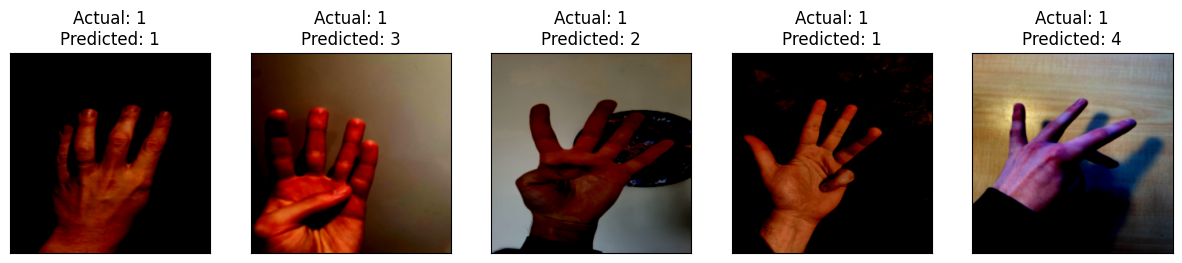

In [88]:
def show_prediction_results(images, actuals, predictions, num_images=5):
    fig = plt.figure(figsize=(15, 6))
    for i, (image, actual, prediction) in enumerate(zip(images, actuals, predictions)):
        if i >= num_images:
            break
        ax = fig.add_subplot(1, num_images, i + 1, xticks=[], yticks=[])
        if image.shape[0] == 3:
            image = image.permute(1, 2, 0)
        if image.max() > 1.0:
            image = image / 255.0
        ax.imshow(image.numpy())
        ax.set_title(f"Actual: {actual}\nPredicted: {prediction}")
    plt.show()

images1, actuals, predictions = [], [], []
with torch.no_grad():
    for images, labels in validate_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        images1.extend(images)
        actuals.extend(labels)
        predictions.extend(preds)
        if len(images1) >= 50:  # Ierobežo attēlu skaitu, lai izvairītos no pārmērīgas datu apstrādes
            break

# Parādiet iegūtos rezultātus
show_prediction_results(images, actuals, predictions, num_images=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


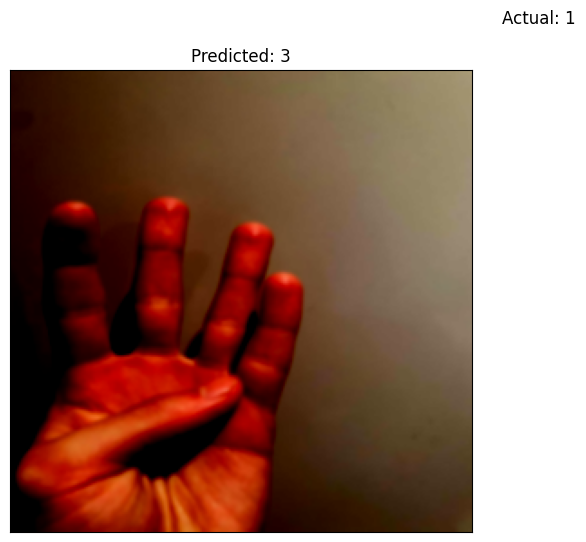

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


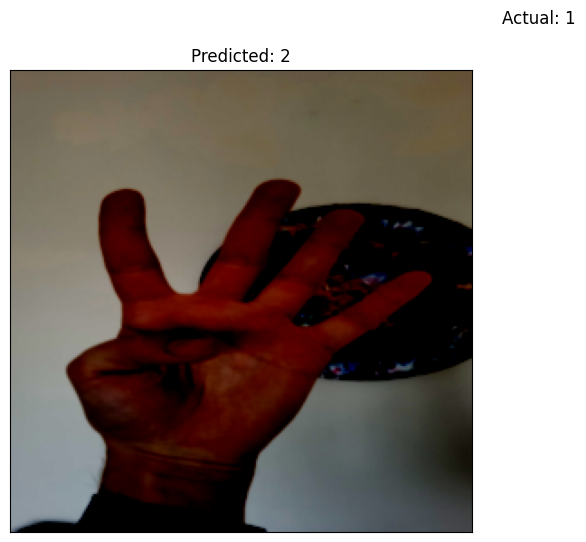

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


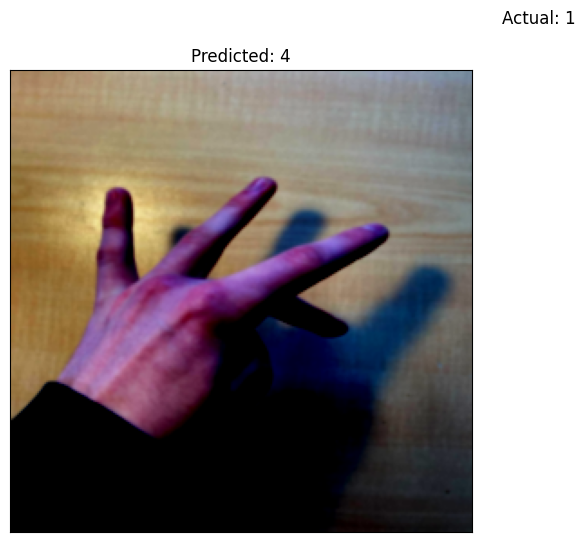

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


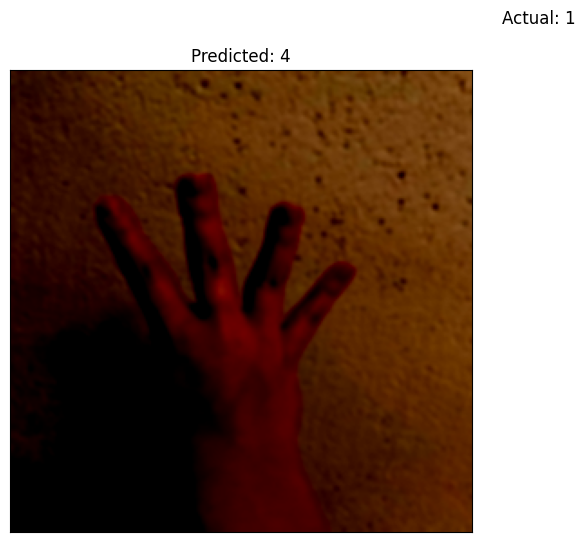

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


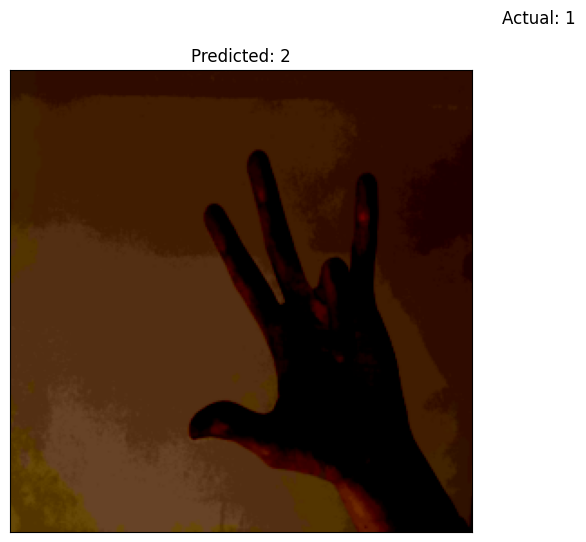

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


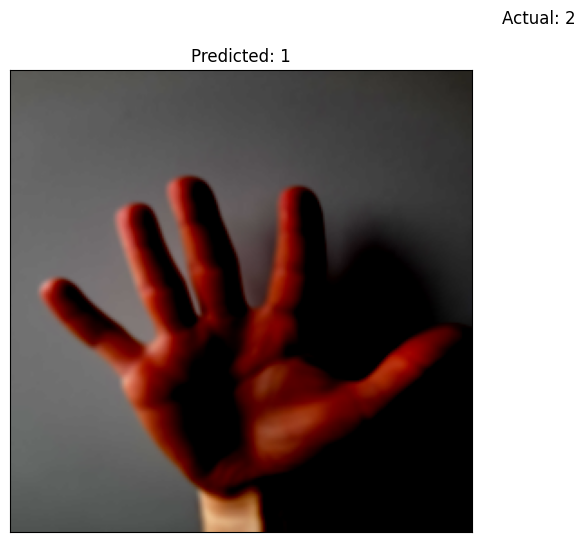

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


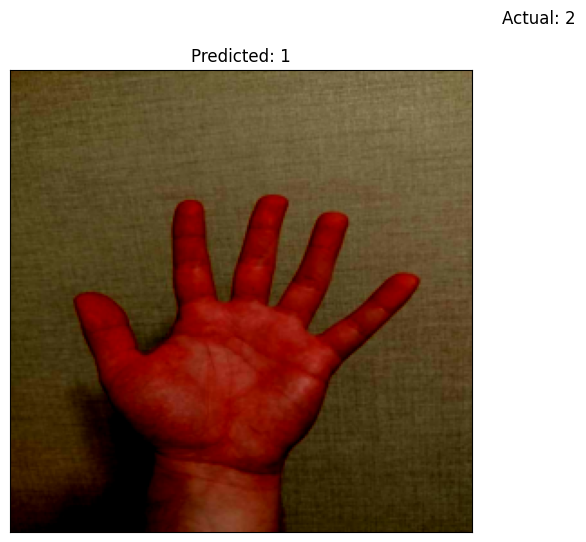

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


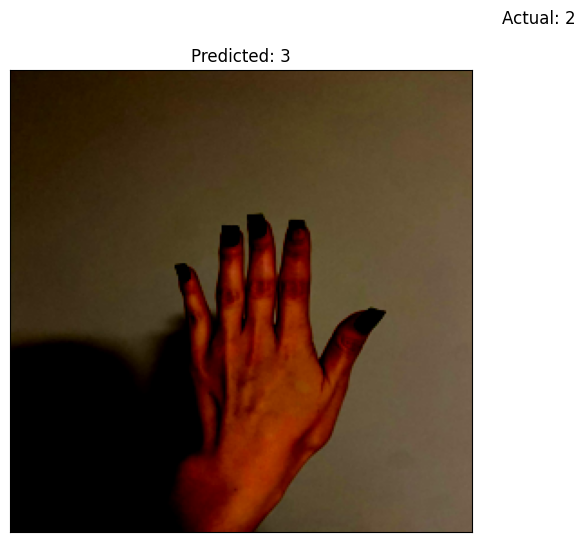

In [89]:
from collections import defaultdict

def show_misclassified_images(images, actuals, predictions, num_images_per_class=2):
    misclassified_images = defaultdict(list)

    # Tiek pievienoti tikai nepareizi klasificēti attēli
    for image, actual, prediction in zip(images, actuals, predictions):
        if int(actual) != int(prediction):
            misclassified_images[actual].append((image, prediction))

    # Iterē cauri katrai klasei un parāda nepareizi klasificētos attēlus
    for actual_label, image_info in misclassified_images.items():
        fig = plt.figure(figsize=(15, 6))
        title_printed = False
        image_count = 0

        for image, predicted_label in image_info:
            if image_count >= num_images_per_class:
                break

            if image.dim() == 3 and image.shape[0] == 3:
                # Pārvērš no (C, H, W) uz (H, W, C) ja attēls ir krāsains
                image = image.permute(1, 2, 0)

            # Ja attēla vērtības ir lielākas par 1, tās tiek normalizētas
            if image.max() > 1.0:
                image = image / 255.0

            ax = fig.add_subplot(1, num_images_per_class, image_count + 1, xticks=[], yticks=[])
            ax.imshow(image.numpy())  # Pārliecinieties, ka attēls tiek konvertēts no Tensor uz Numpy
            ax.set_title(f"Predicted: {predicted_label}")

            if not title_printed:
                plt.suptitle(f"Actual: {actual_label}")
                title_printed = True

            image_count += 1

        plt.show()

show_misclassified_images(images, actuals, predictions)